# What is CVXPY?

CVXPY is a Python-embedded modeling language for convex optimization problems. It allows you to express your problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

### Quick example
For example, the following code solves a least-squares problem with objective function:

$$\|Ax - b\|_2^2$$


In [1]:
import cvxpy as cp
import numpy

# Problem data.
m = 30
n = 20
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
prob = cp.Problem(objective)

# The optimal objective is returned by prob.solve().
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)

status: optimal
optimal value 14.250034142207774
optimal var [-0.13813052  0.04286782 -0.31326036 -0.31875169 -0.38173044  0.103067
  0.24419122 -0.00342188  0.23622057  0.7852978  -0.10776466  0.04355379
  0.02445841  0.34065977 -0.18837811 -0.06417183 -0.06285536 -0.17786598
 -0.077241   -0.05903772]


- `prob.status`, which was assigned a value “optimal” by the solve method, tells us the problem was solved successfully.

- `prob.value`: is the minimum value of the objective.

- `x.value`: values of x that achieve the optimal objective

### Bounded least-squares problem

Again, the objective function is given by: 

$$\|Ax - b\|_2^2.$$

Besides, an additional constraints are imposed:

$$x_i \in [0, 1], \forall i$$

In [2]:
import cvxpy as cp
import numpy

# Problem data.
m = 30
n = 20
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# Solve the convex problem:
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)

status: optimal
optimal value 19.83126370644502
optimal var [-1.79109255e-19  2.85112420e-02  2.79973443e-19  3.37658729e-20
 -2.72802663e-19  1.49285011e-01 -9.94082533e-20  8.35373900e-20
  2.46718649e-01  5.78224144e-01 -4.03739463e-19  1.01242860e-03
 -9.28486180e-20  2.26767464e-01 -1.58813678e-19 -8.97232272e-20
 -1.22145729e-19 -1.51509428e-19  1.12060672e-19 -3.48318635e-19]


### Lasso

Lasso regression is a shrinkage method. It imposes an $\ell_1$ penalty on the parameters. That is, lasso finds an assignment to $\beta$ that minimizes the function:

$$\|X\beta - Y\|_2^2 + \lambda \|\beta\|_1$$

where $\lambda$ is a hyperparameter and, as usual, $X$ is the training data and $Y$ the observations. The penalty encourages sparsity in the learned parameters, and can drive many coefficients to zero. In this sense, lasso is a continuous feature selection method.

We generate training examples and observations that are linearly related; we make the relationship sparse, and we’ll see how to use cvxpy to solve lasso.

In [3]:
import numpy as np

def generate_data(m=100, n=20, sigma=5, density=0.2):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
    for idx in idxs:
        beta_star[idx] = 0
    X = np.random.randn(m,n)
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star

m = 100
n = 20
sigma = 5
density = 0.2

X, Y, _ = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]

#### Objective functions

We can decompose the objective function as the sum of a least squares loss function and an $\ell_1$ regularizer.

In [4]:
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

#### Fitting the model

All we need to do to fit the model is create a CVXPY problem where the objective is to minimize the the objective function defined above. We make $\lambda$ a CVXPY parameter, so that we can use a single CVXPY problem to obtain estimates for many values of $\lambda$.

In [5]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

/Users/zhujin/miniforge3/envs/convex-solver/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Evaluate the model when $\lambda$ changes and visual the training and testing error:

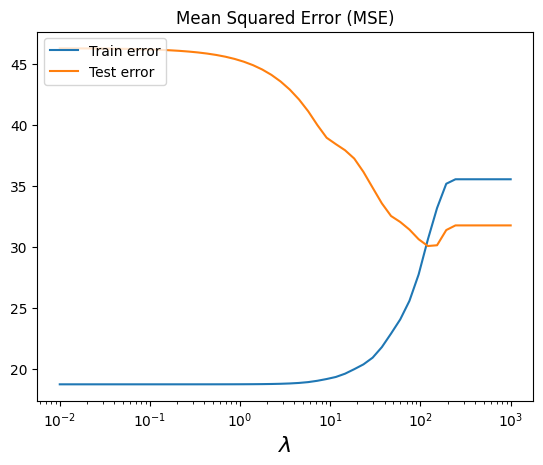

In [6]:
import matplotlib.pyplot as plt

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()

plot_train_test_errors(train_errors, test_errors, lambd_values)